In [ ]:
%%capture
!pip install torchaudio transformers librosa openl3 matplotlib torch torchvision
!pip install langdetect
!pip install torch-audiomentations
!pip install torchlibrosa
!pip install transformers

In [ ]:
import os
import pandas as pd
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from transformers import WhisperModel, AutoProcessor
from transformers import Wav2Vec2Processor, HubertForCTC
import torchaudio
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the DataFrame
df = pd.read_csv('/content/drive/MyDrive/SafeLens Dataset/audio_label_category.csv')

# Step 1: Trim spaces from the 'Category' column
df['Category'] = df['Category'].str.strip()

# Step 2: Replace "Motivational" with "Motivation"
df['Category'] = df['Category'].replace('Motivational', 'Motivation')

# Step 3: Update the 'Category' column with the format "Category_Label"
df['Category'] = df.apply(lambda row: f"{row['Category']}_{row['label']}", axis=1)

# Print the first few rows to verify changes
print(df.head())

                                          audio_path  label      Category
0  /content/drive/MyDrive/SafeLens Dataset/Safe-A...      0      Comedy_0
1  /content/drive/MyDrive/SafeLens Dataset/Safe-A...      0  Motivation_0
2  /content/drive/MyDrive/SafeLens Dataset/Safe-A...      0       Other_0
3  /content/drive/MyDrive/SafeLens Dataset/Safe-A...      0      Comedy_0
4  /content/drive/MyDrive/SafeLens Dataset/Safe-A...      0      Comedy_0


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

In [ ]:
# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=42)

# Save splits
train_df.to_csv('/content/drive/MyDrive/SafeLens Dataset/train_audios.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/SafeLens Dataset/val_audios.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/SafeLens Dataset/test_audios.csv', index=False)

In [ ]:
# Function to extract Whisper features with padding and dtype conversion
def extract_whisper_features(model, processor, audio_data, sr):
    # Prepare the inputs for Whisper model
    inputs = processor(audio_data, sampling_rate=sr, return_tensors="pt", padding=True).input_features.to(device)

    # Check and pad the input features if necessary
    expected_length = 3000  # Expected mel spectrogram length for Whisper
    input_length = inputs.shape[-1]

    if input_length < expected_length:
        padding = expected_length - input_length
        inputs = torch.nn.functional.pad(inputs, (0, padding), mode='constant', value=0)
    elif input_length > expected_length:
        inputs = inputs[:, :, :expected_length]

    # Convert input to float16 if the model is in float16 mode
    if torch_dtype == torch.float16:
        inputs = inputs.half()

    # Use the model encoder directly to get the features
    with torch.no_grad():
        # Extract features using the encoder
        outputs = model.encoder(inputs).last_hidden_state
        embeddings = outputs.mean(dim=1).squeeze(0)

    return embeddings

In [ ]:
def extract_hubert_features(model, processor, audio_data, sr):
    # Prepare the inputs for Hubert model
    inputs = processor(audio_data, sampling_rate=sr, return_tensors="pt", padding=True).input_values.to(device)

    # Use the model to extract the second-last layer's hidden states
    with torch.no_grad():
        outputs = model(input_values=inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        embeddings = hidden_states[-2].mean(dim=1).squeeze(0)  # Second-last layer and average across time

    return embeddings

In [ ]:
# Function to load and preprocess audio
def load_audio_clip(audio_path, clip_length=15, sr=16000):
    audio, sr = librosa.load(audio_path, sr=sr)
    max_length = sr * clip_length
    if len(audio) > max_length:
        audio = audio[:max_length]
    elif len(audio) < max_length:
        padding = max_length - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')
    return audio, sr

In [ ]:
# Dataset class
class AudioDataset(Dataset):
    def __init__(self, dataframe, model="wav2vec2"):
        self.dataframe = dataframe
        self.model = model

        if model == "wav2vec2":
            self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
            self.model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

        if model == "whisper":
            self.processor = AutoProcessor.from_pretrained("openai/whisper-large-v3-turbo")
            self.model = WhisperModel.from_pretrained("openai/whisper-large-v3-turbo", torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True).to(device)

        if model == "hubert":
            self.processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
            self.model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft").to(device)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        audio_path = self.dataframe.iloc[idx]['audio_path']
        label = self.dataframe.iloc[idx]['label']
        category = self.dataframe.iloc[idx]['Category']
        audio_data, sr = load_audio_clip(audio_path)

        if isinstance(self.model, Wav2Vec2Model):  # Wav2Vec2 embeddings
            inputs = self.processor(audio_data, sampling_rate=sr, return_tensors="pt", padding=True)
            with torch.no_grad():
                embeddings = self.model(**inputs).last_hidden_state.mean(dim=1).squeeze(0)

        if isinstance(self.model, WhisperModel):
            embeddings = extract_whisper_features(self.model, self.processor, audio_data, sr)

        if isinstance(self.model, HubertForCTC):
            embeddings = extract_hubert_features(self.model, self.processor, audio_data, sr)

        return torch.tensor(embeddings).float(), torch.tensor(label).long(), audio_path, category


In [ ]:
# Define a simple classifier
class AudioClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(AudioClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def train_model(model, model_save_path, train_loader, val_loader, device='cuda', num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model.to(device)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0

        # Training loop
        for features, labels, _, _ in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_preds / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_preds = 0
        with torch.no_grad():
            for features, labels, _, _ in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct_preds += torch.sum(preds == labels).item()

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_accuracy = val_correct_preds / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

        # Save best model
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")


    # Plot training and validation metrics including training and validation losses and accuracies
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.legend()

    # Set integer ticks for x and y axes
    plt.xticks(range(0, num_epochs+1))  # X-axis should be integer values from 0 to num_epochs-1
    # plt.yticks(range(0, int(max(max(train_losses), max(val_losses))) + 1))  # Y-axis should be integer values up to max loss value

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.legend()

    # Set integer ticks for x and y axes
    plt.xticks(range(0, num_epochs+1))  # X-axis should be integer values from 0 to num_epochs-1
    # plt.yticks(range(0, 101, 5))  # Y-axis should show accuracy from 0 to 100 in steps of 5

    plt.tight_layout()
    plt.show()


In [ ]:
def test_model(model, test_loader, device='cuda'):
    model.eval()
    test_loss = 0.0
    correct_preds = 0
    criterion = nn.CrossEntropyLoss()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for features, labels, _, _ in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()

            # Collect all predictions and true labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_preds / len(test_loader.dataset)

    # Print test loss and accuracy
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Generate and print classification report
    report = classification_report(all_labels, all_preds, target_names=['Safe', 'Unsafe'])
    print("\nClassification Report:\n")
    print(report)
    return all_preds, all_labels


## Training and Testing of Wave2Vec2

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-35-4a25449662e4>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach()

Epoch 1, Loss: 0.6892, Accuracy: 0.5153
Validation Loss: 0.6621, Validation Accuracy: 0.5238
Saved best model with validation loss: 0.6621
Epoch 2, Loss: 0.6838, Accuracy: 0.5357
Validation Loss: 0.6496, Validation Accuracy: 0.5238
Saved best model with validation loss: 0.6496
Epoch 3, Loss: 0.6805, Accuracy: 0.5561
Validation Loss: 0.6477, Validation Accuracy: 0.6190
Saved best model with validation loss: 0.6477
Epoch 4, Loss: 0.6797, Accuracy: 0.5408
Validation Loss: 0.6407, Validation Accuracy: 0.6190
Saved best model with validation loss: 0.6407
Epoch 5, Loss: 0.6771, Accuracy: 0.5867
Validation Loss: 0.6377, Validation Accuracy: 0.5952
Saved best model with validation loss: 0.6377


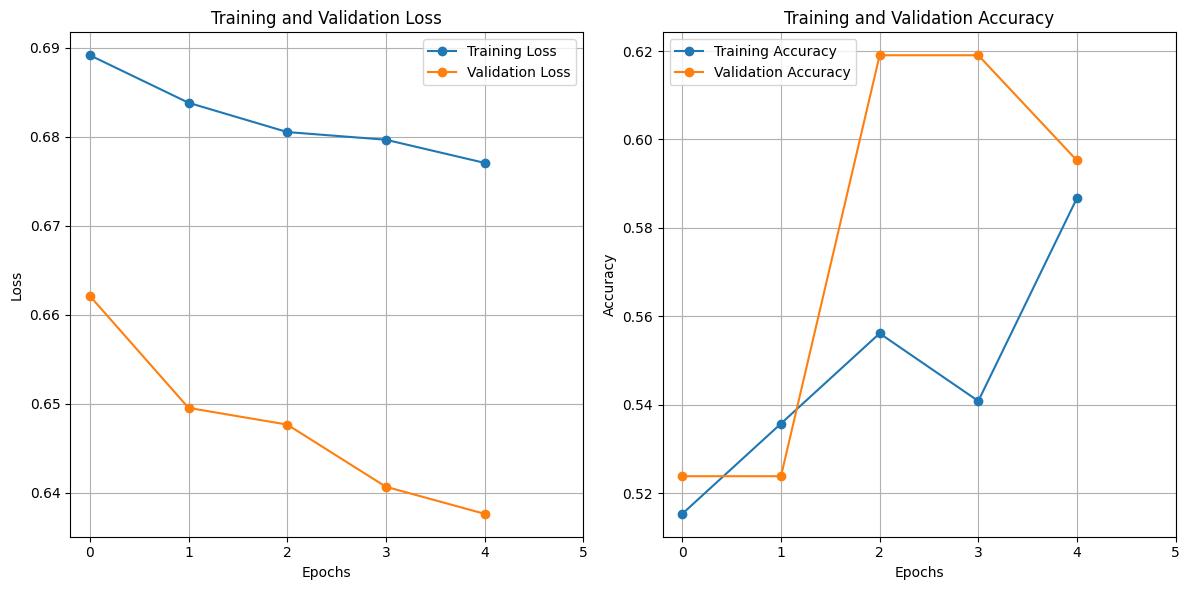

<ipython-input-40-003b10a79372>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Test Loss: 0.6946, Test Accuracy: 0.5238

Classification Report:

              precision    recall  f1-score   support

        Safe       0.54      0.87      0.67        23
      Unsafe       0.40      0.11      0.17        19

    accuracy                           0.52        42
   macro avg       0.47      0.49      0.42        42
weighted avg       0.48      0.52      0.44        42



In [ ]:
# Initialize datasets and dataloaders
batch_size = 8
train_dataset1 = AudioDataset(train_df, model="wav2vec2")
val_dataset1 = AudioDataset(val_df, model="wav2vec2")
test_dataset1 = AudioDataset(test_df, model="wav2vec2")

train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
val_loader1 = DataLoader(val_dataset1, batch_size=batch_size, shuffle=False)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
input_size = 768  # Wav2Vec2 embeddings size
hidden_size = 256
num_classes = 2

model = AudioClassifier(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model = model.to(device)
model_save_path = '/content/drive/MyDrive/SafeLens Dataset/Models/best_wav2vec2_model.pth'

# Train the model
train_model(model, model_save_path, train_loader1, val_loader1, device=device, num_epochs=5)

# Load the best model for testing
model.load_state_dict(torch.load(model_save_path))
predictions, labels = test_model(model, test_loader1, device=device)


In [ ]:
import pandas as pd
import numpy as np

# Convert preds and labels to lists if they are numpy arrays
predictions = predictions.tolist() if isinstance(predictions, np.ndarray) else predictions
labels = labels.tolist() if isinstance(labels, np.ndarray) else labels

# Access the audio paths and categories from the test dataset
audio_paths = [test_dataset1.dataframe.iloc[i, 0] for i in range(len(test_dataset1))]
categories = [test_dataset1.dataframe.iloc[i, 2] for i in range(len(test_dataset1))]

# Create a new DataFrame
new_data = {'audio_path': audio_paths, 'category': categories, 'preds': predictions, 'labels': labels}
new_df = pd.DataFrame(new_data)
new_df.to_csv("/content/drive/MyDrive/SafeLens Dataset/Audio_FMGAI_Final/audio_test_predictions_1.csv", index=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

# Load the predictions CSV file
df = pd.read_csv("/content/drive/MyDrive/SafeLens Dataset/Audio_FMGAI_Final/audio_test_predictions_1.csv")

# Get the unique categories
categories = df['category'].unique()

# Initialize a DataFrame to store metrics for each category
category_metrics_df = pd.DataFrame(columns=['Category', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Iterate over each category and calculate metrics
for category in categories:
    category_df = df[df['category'] == category]
    y_true = category_df['labels']
    y_pred = category_df['preds']

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    # Append metrics to the DataFrame using loc
    category_metrics_df.loc[len(category_metrics_df)] = {
        'Category': category,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Print the per-category metrics DataFrame
print("\nCategory-wise Metrics:")
print(category_metrics_df)

# Calculate and print overall metrics
y_true_overall = df['labels']
y_pred_overall = df['preds']

overall_accuracy = accuracy_score(y_true_overall, y_pred_overall)
overall_precision = precision_score(y_true_overall, y_pred_overall, average='weighted', zero_division=1)
overall_recall = recall_score(y_true_overall, y_pred_overall, average='weighted', zero_division=1)
overall_f1 = f1_score(y_true_overall, y_pred_overall, average='weighted', zero_division=1)

# Print overall classification metrics
print("\nOverall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")

# Print the overall classification report
print("\nOverall Classification Report:")
print(classification_report(y_true_overall, y_pred_overall, zero_division=1))




Category-wise Metrics:
         Category  Accuracy  Precision    Recall  F1 Score
0   Information_0  0.625000        1.0  0.625000  0.769231
1      Threaten_1  0.000000        1.0  0.000000  0.000000
2        Vulgar_1  0.166667        1.0  0.166667  0.285714
3         Other_0  1.000000        1.0  1.000000  1.000000
4         Other_1  0.000000        1.0  0.000000  0.000000
5          Song_0  1.000000        1.0  1.000000  1.000000
6        Comedy_0  1.000000        1.0  1.000000  1.000000
7    Motivation_0  1.000000        1.0  1.000000  1.000000

Overall Metrics:
Accuracy: 0.5238
Precision: 0.4770
Recall: 0.5238
F1 Score: 0.4405

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.87      0.67        23
           1       0.40      0.11      0.17        19

    accuracy                           0.52        42
   macro avg       0.47      0.49      0.42        42
weighted avg       0.48      0.52      0.44        42



## Training and Testing of Whisper

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

<ipython-input-9-4a25449662e4>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(embeddings).float(), torch.tensor(label).long(), audio_path, category


Epoch 1, Loss: 0.6890, Accuracy: 0.5051
Validation Loss: 0.6714, Validation Accuracy: 0.5238
Saved best model with validation loss: 0.6714
Epoch 2, Loss: 0.6669, Accuracy: 0.7194
Validation Loss: 0.6605, Validation Accuracy: 0.7857
Saved best model with validation loss: 0.6605
Epoch 3, Loss: 0.6453, Accuracy: 0.7296
Validation Loss: 0.6400, Validation Accuracy: 0.7619
Saved best model with validation loss: 0.6400
Epoch 4, Loss: 0.6256, Accuracy: 0.8163
Validation Loss: 0.6230, Validation Accuracy: 0.7619
Saved best model with validation loss: 0.6230
Epoch 5, Loss: 0.5990, Accuracy: 0.8265
Validation Loss: 0.6003, Validation Accuracy: 0.7619
Saved best model with validation loss: 0.6003


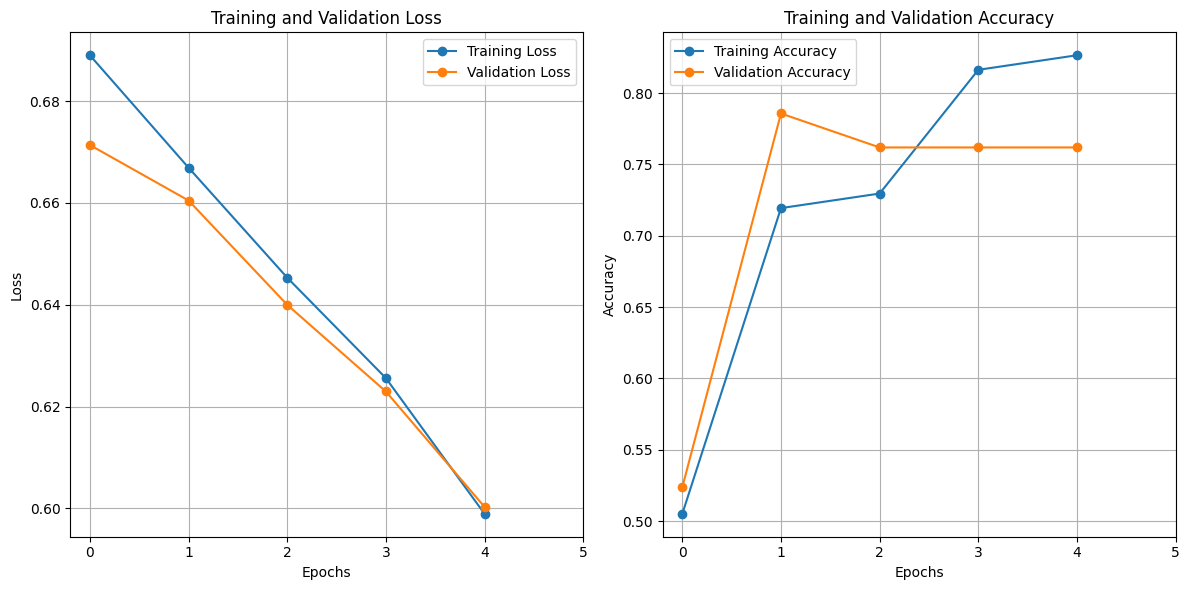

<ipython-input-13-2a8b48288fa8>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Test Loss: 0.6033, Test Accuracy: 0.7857

Classification Report:

              precision    recall  f1-score   support

        Safe       0.73      0.96      0.83        23
      Unsafe       0.92      0.58      0.71        19

    accuracy                           0.79        42
   macro avg       0.82      0.77      0.77        42
weighted avg       0.82      0.79      0.78        42



In [ ]:
# Initialize datasets and dataloaders
batch_size = 8
train_dataset2 = AudioDataset(train_df, model="whisper")
val_dataset2 = AudioDataset(val_df, model="whisper")
test_dataset2 = AudioDataset(test_df, model="whisper")

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
input_size = 1280
hidden_size = 256
num_classes = 2

model = AudioClassifier(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model = model.to(device)
model_save_path = '/content/drive/MyDrive/SafeLens Dataset/Models/best_whisper_model.pth'

# Train the model
train_model(model, model_save_path, train_loader2, val_loader2, device=device, num_epochs=5)

# Load the best model for testing
model.load_state_dict(torch.load(model_save_path))
predictions, labels = test_model(model, test_loader2, device=device)


In [ ]:
import pandas as pd
import numpy as np

# Convert preds and labels to lists if they are numpy arrays
predictions = predictions.tolist() if isinstance(predictions, np.ndarray) else predictions
labels = labels.tolist() if isinstance(labels, np.ndarray) else labels

# Access the audio paths and categories from the test dataset
audio_paths = [test_dataset2.dataframe.iloc[i, 0] for i in range(len(test_dataset2))]
categories = [test_dataset2.dataframe.iloc[i, 2] for i in range(len(test_dataset2))]

# Create a new DataFrame
new_data = {'audio_path': audio_paths, 'category': categories, 'preds': predictions, 'labels': labels}
new_df = pd.DataFrame(new_data)
new_df.to_csv("/content/audio_test_predictions_2.csv", index=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

# Load the predictions CSV file
df = pd.read_csv("/content/drive/MyDrive/SafeLens Dataset/Audio_FMGAI_Final/audio_test_predictions_2.csv")

# Get the unique categories
categories = df['category'].unique()

# Initialize a DataFrame to store metrics for each category
category_metrics_df = pd.DataFrame(columns=['Category', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Iterate over each category and calculate metrics
for category in categories:
    category_df = df[df['category'] == category]
    y_true = category_df['labels']
    y_pred = category_df['preds']

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    # Append metrics to the DataFrame using loc
    category_metrics_df.loc[len(category_metrics_df)] = {
        'Category': category,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Print the per-category metrics DataFrame
print("\nCategory-wise Metrics:")
print(category_metrics_df)

# Calculate and print overall metrics
y_true_overall = df['labels']
y_pred_overall = df['preds']

overall_accuracy = accuracy_score(y_true_overall, y_pred_overall)
overall_precision = precision_score(y_true_overall, y_pred_overall, average='weighted', zero_division=1)
overall_recall = recall_score(y_true_overall, y_pred_overall, average='weighted', zero_division=1)
overall_f1 = f1_score(y_true_overall, y_pred_overall, average='weighted', zero_division=1)

# Print overall classification metrics
print("\nOverall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")

# Print the overall classification report
print("\nOverall Classification Report:")
print(classification_report(y_true_overall, y_pred_overall, zero_division=1))



Category-wise Metrics:
        Category  Accuracy  Precision    Recall  F1 Score
0  Information_0  1.000000        1.0  1.000000  1.000000
1     Threaten_1  0.666667        1.0  0.666667  0.800000
2       Vulgar_1  0.583333        1.0  0.583333  0.736842
3        Other_0  1.000000        1.0  1.000000  1.000000
4        Other_1  0.000000        1.0  0.000000  0.000000
5         Song_0  0.666667        1.0  0.666667  0.800000
6       Comedy_0  1.000000        1.0  1.000000  1.000000
7   Motivation_0  1.000000        1.0  1.000000  1.000000

Overall Metrics:
Accuracy: 0.7857
Precision: 0.8163
Recall: 0.7857
F1 Score: 0.7757

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        23
           1       0.92      0.58      0.71        19

    accuracy                           0.79        42
   macro avg       0.82      0.77      0.77        42
weighted avg       0.82      0.79      0.78        42



## Training and Testing of Hubert

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

<ipython-input-10-4a25449662e4>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(embeddings).float(), torch.tensor(label).long(), audio_path, category


Epoch 1, Loss: 2.5335, Accuracy: 0.5204
Validation Loss: 1.2067, Validation Accuracy: 0.6667
Saved best model with validation loss: 1.2067
Epoch 2, Loss: 1.2819, Accuracy: 0.5969
Validation Loss: 0.6607, Validation Accuracy: 0.7857
Saved best model with validation loss: 0.6607
Epoch 3, Loss: 0.7067, Accuracy: 0.7245
Validation Loss: 0.7068, Validation Accuracy: 0.7381
Epoch 4, Loss: 0.7973, Accuracy: 0.5969
Validation Loss: 0.5184, Validation Accuracy: 0.6905
Saved best model with validation loss: 0.5184
Epoch 5, Loss: 0.5231, Accuracy: 0.7347
Validation Loss: 0.4930, Validation Accuracy: 0.7619
Saved best model with validation loss: 0.4930


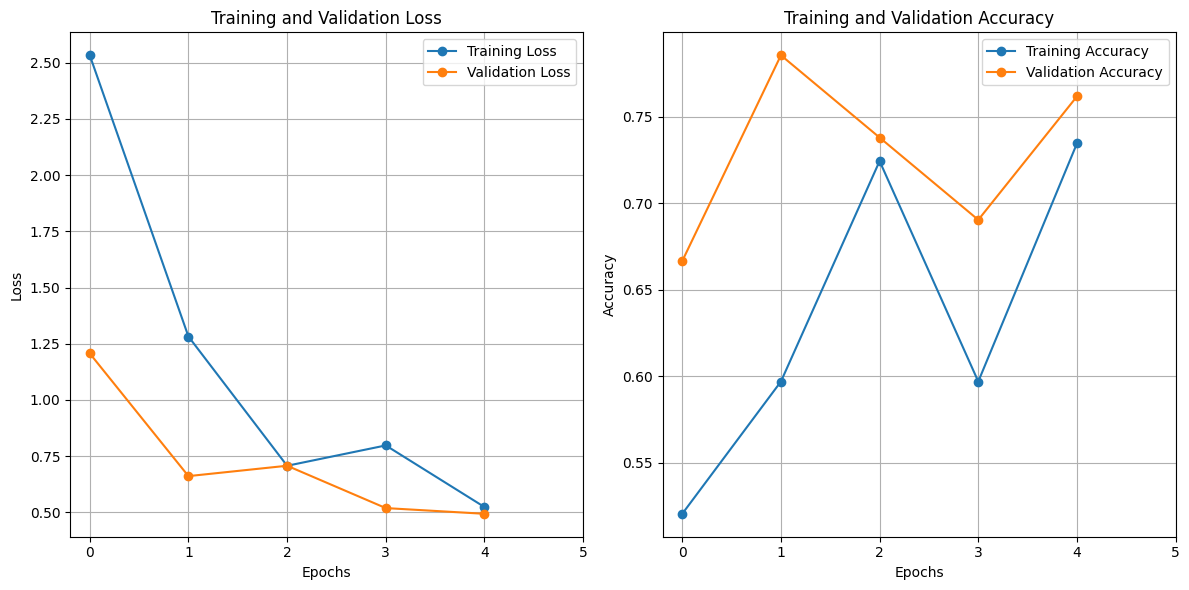

<ipython-input-14-a3c12c69dd0e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Test Loss: 0.5158, Test Accuracy: 0.7143

Classification Report:

              precision    recall  f1-score   support

        Safe       0.70      0.83      0.76        23
      Unsafe       0.73      0.58      0.65        19

    accuracy                           0.71        42
   macro avg       0.72      0.70      0.70        42
weighted avg       0.72      0.71      0.71        42



In [ ]:
# Initialize datasets and dataloaders
batch_size = 8
train_dataset3 = AudioDataset(train_df, model="hubert")
val_dataset3 = AudioDataset(val_df, model="hubert")
test_dataset3 = AudioDataset(test_df, model="hubert")

train_loader3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
val_loader3 = DataLoader(val_dataset3, batch_size=batch_size, shuffle=False)
test_loader3 = DataLoader(test_dataset3, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
input_size = 1024  # Hubert large embeddings size (check model documentation)
hidden_size = 256
num_classes = 2

model = AudioClassifier(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model = model.to(device)
model_save_path = '/content/drive/MyDrive/SafeLens Dataset/Models/best_hubert_model.pth'

# Train the model
train_model(model, model_save_path, train_loader3, val_loader3, device=device, num_epochs=5)

# Load the best model for testing
model.load_state_dict(torch.load(model_save_path))
# test_model(model, test_loader3, device=device)


predictions, labels = test_model(model, test_loader3, device=device)


In [ ]:
import pandas as pd
import numpy as np

# Convert preds and labels to lists if they are numpy arrays
predictions = predictions.tolist() if isinstance(predictions, np.ndarray) else predictions
labels = labels.tolist() if isinstance(labels, np.ndarray) else labels

# Access the audio paths and categories from the test dataset
audio_paths = [test_dataset3.dataframe.iloc[i, 0] for i in range(len(test_dataset3))]
categories = [test_dataset3.dataframe.iloc[i, 2] for i in range(len(test_dataset3))]

# Create a new DataFrame
new_data = {'audio_path': audio_paths, 'category': categories, 'preds': predictions, 'labels': labels}
new_df = pd.DataFrame(new_data)
new_df.to_csv("/content/drive/MyDrive/SafeLens Dataset/Audio_FMGAI_Final/audio_test_predictions_3.csv", index=False)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

# Load the predictions CSV file
df = pd.read_csv("/content/drive/MyDrive/SafeLens Dataset/Audio_FMGAI_Final/audio_test_predictions_3.csv")

# Get the unique categories
categories = df['category'].unique()

# Initialize a DataFrame to store metrics for each category
category_metrics_df = pd.DataFrame(columns=['Category', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Iterate over each category and calculate metrics
for category in categories:
    category_df = df[df['category'] == category]
    y_true = category_df['labels']
    y_pred = category_df['preds']

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    # Append metrics to the DataFrame using loc
    category_metrics_df.loc[len(category_metrics_df)] = {
        'Category': category,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Print the per-category metrics DataFrame
print("\nCategory-wise Metrics:")
print(category_metrics_df)

# Calculate and print overall metrics
y_true_overall = df['labels']
y_pred_overall = df['preds']

overall_accuracy = accuracy_score(y_true_overall, y_pred_overall)
overall_precision = precision_score(y_true_overall, y_pred_overall, average='weighted', zero_division=1)
overall_recall = recall_score(y_true_overall, y_pred_overall, average='weighted', zero_division=1)
overall_f1 = f1_score(y_true_overall, y_pred_overall, average='weighted', zero_division=1)

# Print overall classification metrics
print("\nOverall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")

# Print the overall classification report
print("\nOverall Classification Report:")
print(classification_report(y_true_overall, y_pred_overall, zero_division=1))



Category-wise Metrics:
        Category  Accuracy  Precision    Recall  F1 Score
0  Information_0  0.875000        1.0  0.875000  0.933333
1     Threaten_1  0.500000        1.0  0.500000  0.666667
2       Vulgar_1  0.666667        1.0  0.666667  0.800000
3        Other_0  0.833333        1.0  0.833333  0.909091
4        Other_1  0.000000        1.0  0.000000  0.000000
5         Song_0  0.666667        1.0  0.666667  0.800000
6       Comedy_0  0.666667        1.0  0.666667  0.800000
7   Motivation_0  1.000000        1.0  1.000000  1.000000

Overall Metrics:
Accuracy: 0.7143
Precision: 0.7171
Recall: 0.7143
F1 Score: 0.7089

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        23
           1       0.73      0.58      0.65        19

    accuracy                           0.71        42
   macro avg       0.72      0.70      0.70        42
weighted avg       0.72      0.71      0.71        42

